In [41]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
from datetime import timedelta
 

In [3]:
ubisoft_data = yf.download("UBI.PA", end="2025-01-12", interval="1d")
taketwo_data = yf.download("TTWO", start="2000-01-02", end="2025-01-12", interval="1d")

ubisoft_data.to_csv("ubisoft_data.csv")
taketwo_data.to_csv("taketwo_data.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
ubisoft_data.shape, taketwo_data.shape

((6433, 5), (6295, 5))

In [5]:
df = pd.DataFrame(index=taketwo_data.index)
df['t2i'] = taketwo_data['Close']
df = df.merge(ubisoft_data['Close'], how='left', left_index=True, right_index=True)

In [6]:
df = df.asfreq('b')

In [7]:
print(df.isnull().sum())
df = df.fillna(method='ffill')

t2i       235
UBI.PA    282
dtype: int64


C:\Users\ahmad\AppData\Local\Temp\ipykernel_29312\3667842599.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [8]:
adfuller(df[ 't2i'])

(0.1405951294755122,
 0.9687258857741953,
 35,
 6494,
 {'1%': -3.4313573739961654,
  '5%': -2.861985172918986,
  '10%': -2.567006962204054},
 24866.739119423415)

In [9]:
# Calculating the returns to make the data stationary
df['t2i_returns'] = df['t2i'].pct_change()
df['ubisoft_returns'] = df['UBI.PA'].pct_change()

In [10]:
size = int(len(df)*0.8)
df = df[1:] # Removing the first row for Returns
df_train = df[:size]
df_test = df[size:]

In [11]:
adfuller(df[ 't2i_returns'])

(-20.228460186003414,
 0.0,
 17,
 6511,
 {'1%': -3.4313547427387996,
  '5%': -2.861984010325392,
  '10%': -2.5670063433303247},
 -27010.79742081742)

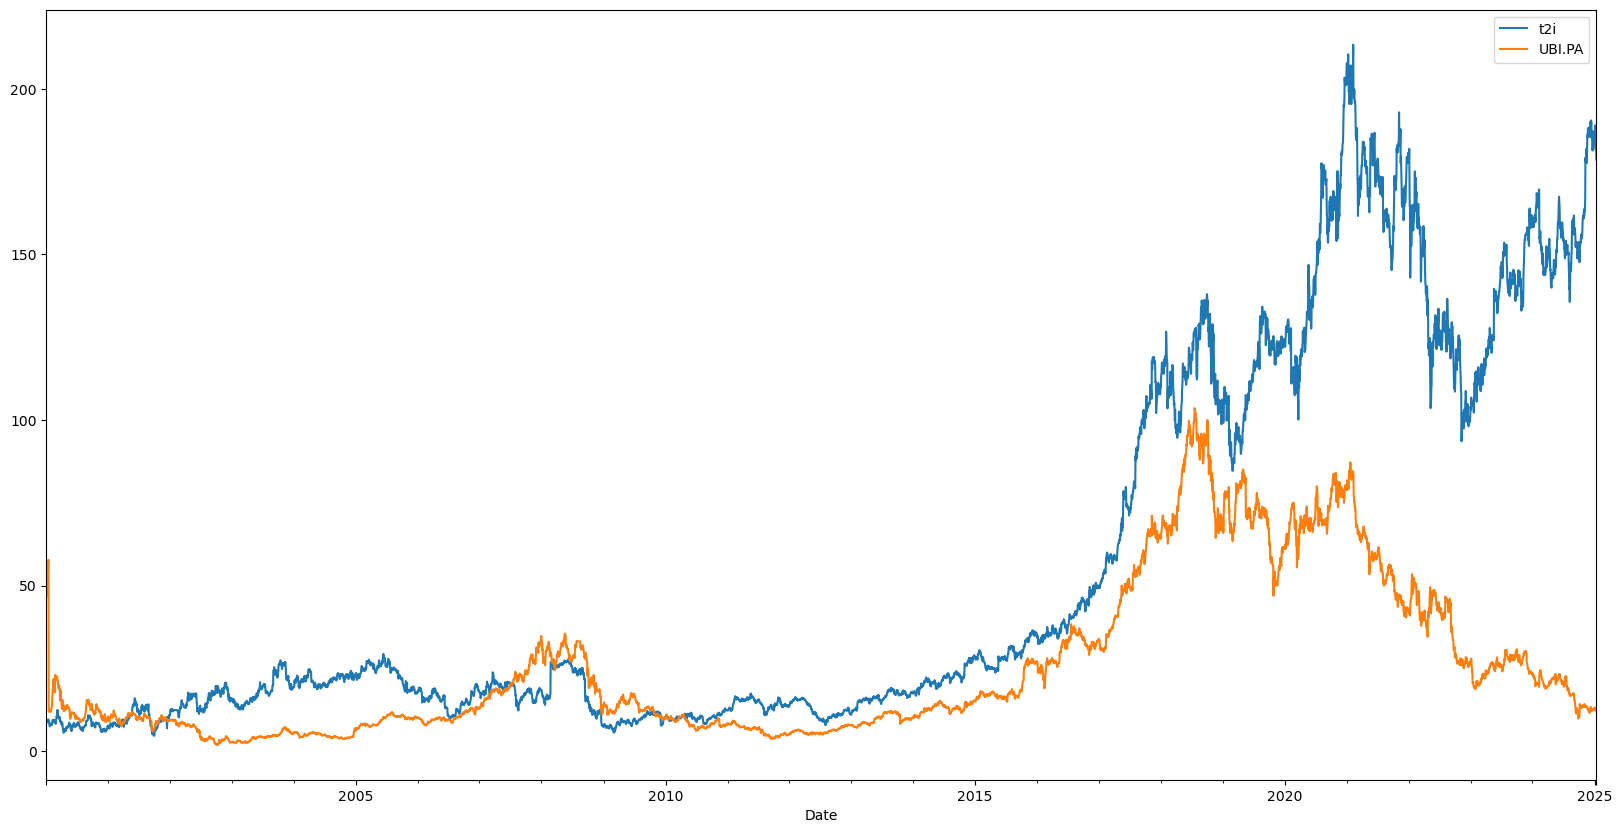

In [12]:
# PLotting the data
%matplotlib inline
df[["t2i", "UBI.PA"]].plot(figsize=(20,10))
plt.legend()

Text(0.5, 1.0, 'ubisoft returns')

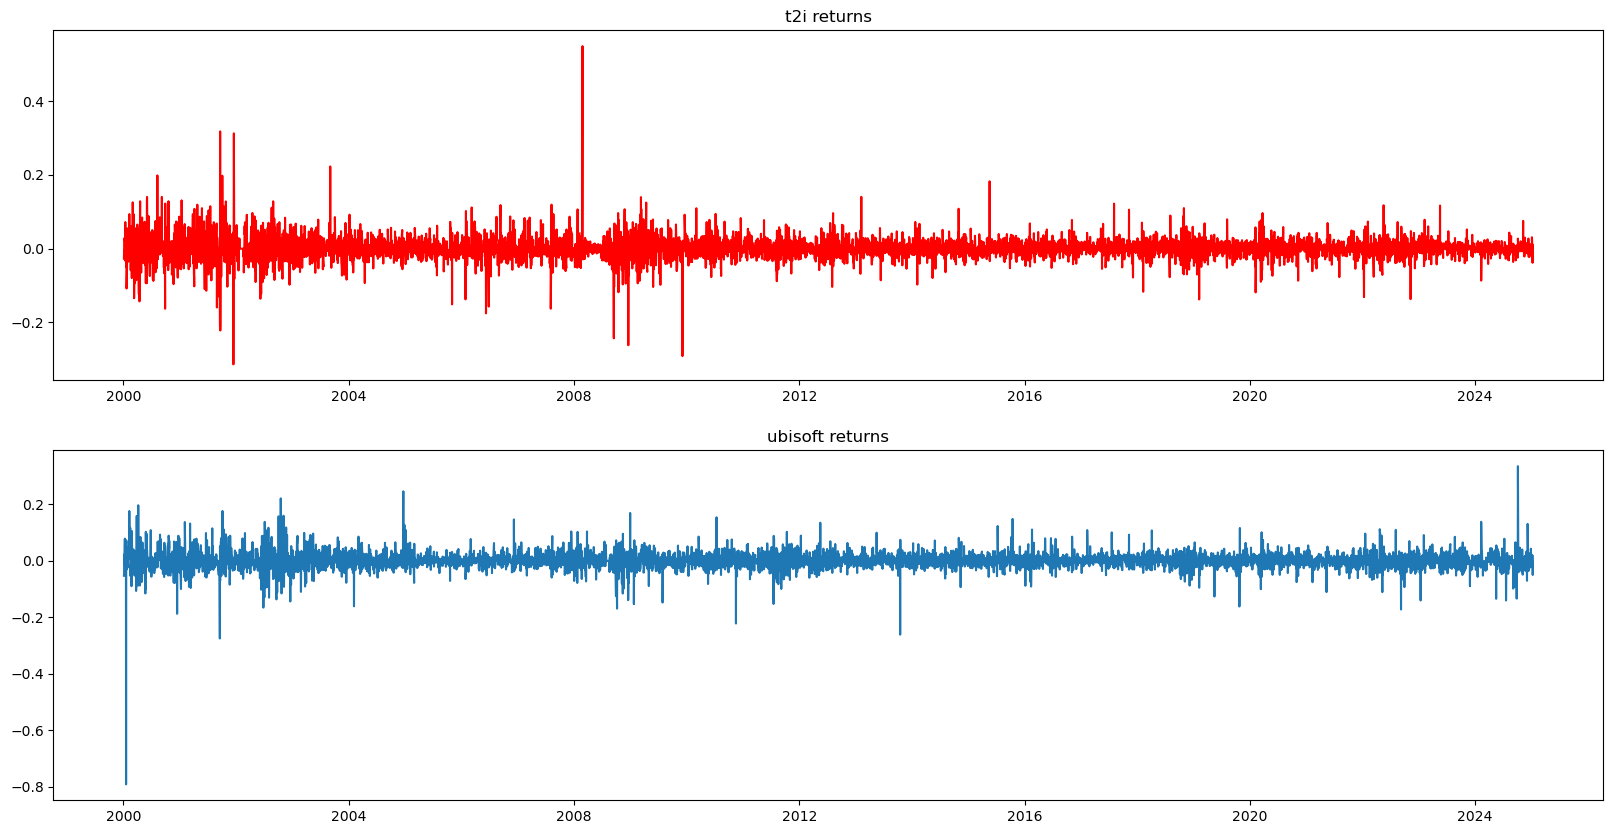

In [13]:
# plotting Returns
plt.figure(figsize=(20,10))

plt.subplot(211)
plt.plot(df[['t2i_returns']],color = 'red')
plt.title('t2i returns')

plt.subplot(212)
plt.plot(df[['ubisoft_returns']])
plt.title('ubisoft returns')

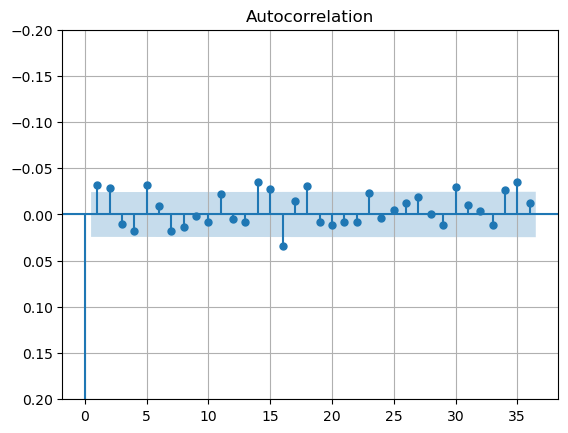

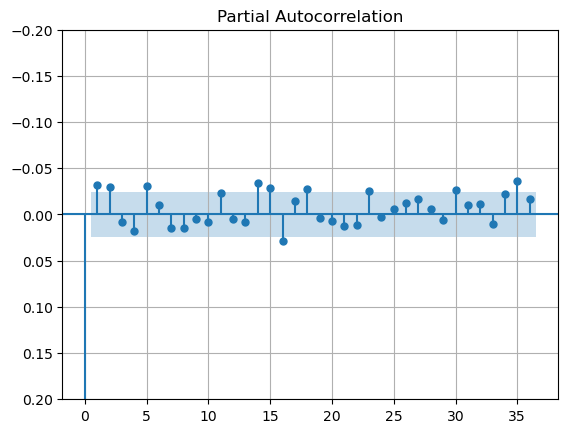

In [14]:
plot_acf(df[ 't2i_returns'], lags=36)
plt.ylim(0.2,-0.2)
plt.grid()
plot_pacf(df[ 't2i_returns'], lags=36, method="ols")
plt.ylim(0.2,-0.2)
plt.grid()

plt.show()

### ACF cutoff determine the order of the MA model
### PACF cutoff determine the order of the AR model

In [78]:
def model_predictor(model,test_data,n_predictions=30,exog = None,plot = False, returns = False):
    model_fit = model.fit()
    display(model_fit.summary())
    n_predictions = min(n_predictions, len(test_data) - 1)
    # predicting
    if exog is not None:
        exog = exog[:n_predictions+1]
    
    # plotting predictions
    if plot:
        start = test_data.index[0]
        end = test_data.index[min(n_predictions, len(test_data) - 1)]
        df_pred = model_fit.predict(
                                start = start, 
                                end = end,
                                exog = exog)
        if returns:
            plt.plot(df_pred, label = 'Predictions')
            plt.plot(test_data[:len(df_pred)], label = 'Actual')
        else:
            plt.plot(df_pred.cumsum(), label = 'Predictions')
            plt.plot(test_data[:len(df_pred)].cumsum(), label = 'Actual')
        plt.title(model.order)
        plt.xticks(rotation = 90)
        plt.legend()
    return model_fit

Unlike the prices data, the returns are stationary

### Simple AR model

### Using returns instead since they are stationary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(1, 0, 0)   Log Likelihood               10541.707
Date:                Sun, 19 Jan 2025   AIC                         -21077.413
Time:                        05:39:12   BIC                         -21057.730
Sample:                    01-04-2000   HQIC                        -21070.530
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.315      0.021       0.000       0.002
ar.L1         -0.0290      0.006     -4.680      0.000      -0.041      -0.017
sigma2         0.0010   5.38e-06    192.299      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            166566.52
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

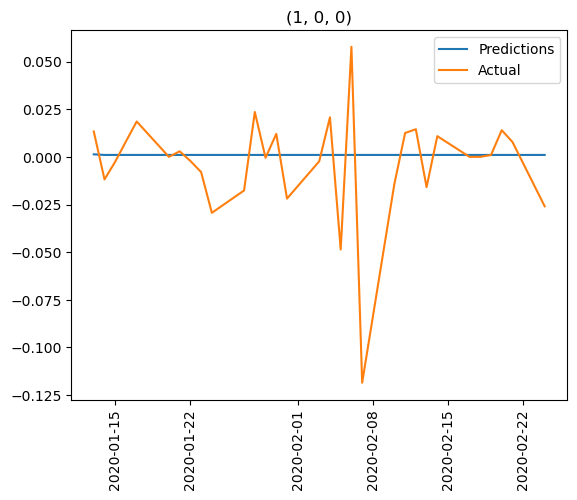

In [16]:
# AR model with returns
model = ARIMA(df_train[ 't2i_returns'], order=(1,0,0))
model_predictor(model,df_test[ 't2i_returns'], plot = True)

Explanation:
    The model is not able to predict the future values because every day is based on only the previous day

### Simple MA model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(0, 0, 1)   Log Likelihood               10541.849
Date:                Sun, 19 Jan 2025   AIC                         -21077.697
Time:                        05:39:13   BIC                         -21058.014
Sample:                    01-04-2000   HQIC                        -21070.814
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.313      0.021       0.000       0.002
ma.L1         -0.0296      0.006     -4.751      0.000      -0.042      -0.017
sigma2         0.0010   5.38e-06    192.342      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            166541.64
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

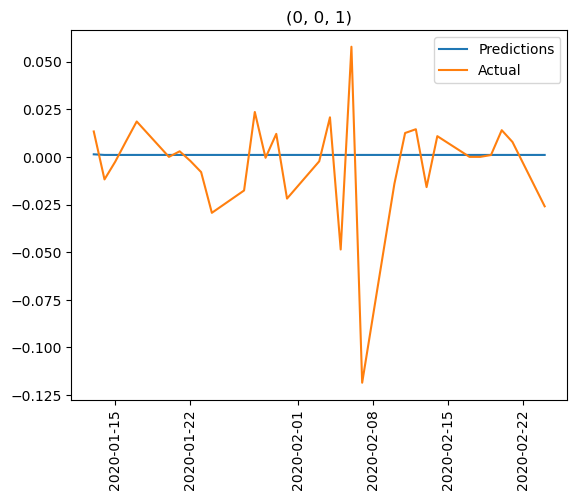

In [17]:
# MA model with returns
model = ARIMA(df_train[ 't2i_returns'], order=(0,0,1))
model_predictor(model,df_test[ 't2i_returns'], plot = True)

Note: that all parameters are significantly different from zero.

Explanation:
    Moving average models only depend on forecast residuals from the previous prediction, which doesn't represent the data

### Conclusion
Simple AR, MA models is not going to cut it

### Using Higher order AR and MA

In [18]:
model = ARIMA(df_train[ 't2i_returns'], order=(5,0,0))
model_predictor(model, df_test[ 't2i_returns'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(5, 0, 0)   Log Likelihood               10548.477
Date:                Sun, 19 Jan 2025   AIC                         -21082.954
Time:                        05:39:16   BIC                         -21037.027
Sample:                    01-04-2000   HQIC                        -21066.893
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.318      0.020       0.000       0.002
ar.L1         -0.0292      0.006     -4.599      0.000      -0.042      -0.017
ar.L2         -0.0306      0.009     -3.456      0.001      -0.048      -0.013
ar.L3          0.0122      0.012      1.038      0.299      -0.011       0.035
ar.L4          0.0212      0.012      1.837      0.066      -0.001       0.044
ar.L5         -0.0304      0.012     -2.497      0.013      -0.054      -0.007
sigma2         0.0010   5.58e-06    184.834      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            166510.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model = ARIMA(df_train[ 't2i_returns'], order=(0,0,5))
model_predictor(model, df_test[ 't2i_returns'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(0, 0, 5)   Log Likelihood               10548.250
Date:                Sun, 19 Jan 2025   AIC                         -21082.501
Time:                        05:39:18   BIC                         -21036.574
Sample:                    01-04-2000   HQIC                        -21066.440
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.323      0.020       0.000       0.002
ma.L1         -0.0305      0.006     -4.804      0.000      -0.043      -0.018
ma.L2         -0.0297      0.009     -3.383      0.001      -0.047      -0.012
ma.L3          0.0140      0.012      1.194      0.232      -0.009       0.037
ma.L4          0.0213      0.011      1.870      0.061      -0.001       0.044
ma.L5         -0.0320      0.012     -2.602      0.009      -0.056      -0.008
sigma2         0.0010   5.62e-06    183.598      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            166147.34
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Conclusion
Higher order AR and MA models don't make a difference

# Simple ARMA model

In [20]:
models = {}
models_fit = {}

In [21]:
models['1 1'] = ARIMA(df_train[ 't2i_returns'], order=(1,0,1))
model_predictor(models['1 1'], df_test[ 't2i_returns'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(1, 0, 1)   Log Likelihood               10542.777
Date:                Sun, 19 Jan 2025   AIC                         -21077.554
Time:                        05:39:20   BIC                         -21051.310
Sample:                    01-04-2000   HQIC                        -21068.376
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.326      0.020       0.000       0.002
ar.L1          0.2548      0.216      1.181      0.238      -0.168       0.678
ma.L1         -0.2892      0.215     -1.343      0.179      -0.711       0.133
sigma2         0.0010    5.4e-06    191.390      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):            166518.95
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Notice how AR component is positive meaning the predictions is moving in consecutive positive of negative values,

While the MA component being negative suggests moving away from past values.

# High order ARMA

In [22]:
models['3 3'] = ARIMA(df_train[ 't2i_returns'], order=(3,0,3))
models_fit['3 3'] = model_predictor(models['3 3'], df_test[ 't2i_returns'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(3, 0, 3)   Log Likelihood               10545.628
Date:                Sun, 19 Jan 2025   AIC                         -21075.256
Time:                        05:39:26   BIC                         -21022.768
Sample:                    01-04-2000   HQIC                        -21056.901
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.301      0.021       0.000       0.002
ar.L1         -0.5277      0.929     -0.568      0.570      -2.348       1.293
ar.L2         -0.8056      0.195     -4.125      0.000      -1.188      -0.423
ar.L3         -0.1696      0.675     -0.251      0.802      -1.492       1.153
ma.L1          0.4996      0.930      0.537      0.591      -1.323       2.322
ma.L2          0.7680      0.181      4.247      0.000       0.414       1.122
ma.L3          0.1482      0.653      0.227      0.821      -1.132       1.428
sigma2         0.0010   5.69e-06    181.374      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            167603.65
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model has non-significant coefs

Since the AR and MA models complement each other, it makes sense to use lower order for ARMA model, since components will cancel each other out on high orders

Sooo, the model is unnecessarily complicated

In [23]:
def LLR_test(model1, model2, df = 1):
    ll1 = model1.fit().llf
    ll2 = model2.fit().llf
    llr_stats = 2 * (ll2 - ll1)
    p = chi2.sf(llr_stats, df).round(3)
    return p

In [24]:
models['3 2'] = ARIMA(df_train[ 't2i_returns'], order=(3,0,2))
models_fit['3 2'] = model_predictor(models['3 2'] , df_test[ 't2i_returns'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(3, 0, 2)   Log Likelihood               10552.779
Date:                Sun, 19 Jan 2025   AIC                         -21091.558
Time:                        05:39:29   BIC                         -21045.631
Sample:                    01-04-2000   HQIC                        -21075.497
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.349      0.019       0.000       0.002
ar.L1         -0.8669      0.056    -15.456      0.000      -0.977      -0.757
ar.L2         -0.9109      0.039    -23.447      0.000      -0.987      -0.835
ar.L3         -0.0467      0.010     -4.476      0.000      -0.067      -0.026
ma.L1          0.8349      0.055     15.061      0.000       0.726       0.944
ma.L2          0.8496      0.042     20.230      0.000       0.767       0.932
sigma2         0.0010   5.66e-06    181.924      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):            166560.54
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### it yeilded all significant coefs still exist

In [25]:
LLR_test(models['3 2'], models['3 3'])

1.0

Model 1 isn't significantly better than model 2, since the two models are nested, it is better to use aic and llf to differentiate between them

In [26]:
models['2 3'] = ARIMA(df_train[ 't2i_returns'], order=(2,0,3))
models_fit['2 3'] = model_predictor(models['2 3'] , df_test[ 't2i_returns'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(2, 0, 3)   Log Likelihood               10544.594
Date:                Sun, 19 Jan 2025   AIC                         -21075.189
Time:                        05:39:42   BIC                         -21029.262
Sample:                    01-04-2000   HQIC                        -21059.128
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.313      0.021       0.000       0.002
ar.L1         -0.3558      0.153     -2.326      0.020      -0.656      -0.056
ar.L2         -0.7932      0.132     -5.991      0.000      -1.053      -0.534
ma.L1          0.3257      0.153      2.128      0.033       0.026       0.626
ma.L2          0.7632      0.135      5.666      0.000       0.499       1.027
ma.L3         -0.0204      0.014     -1.499      0.134      -0.047       0.006
sigma2         0.0010   5.79e-06    178.444      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            167757.50
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We should look for higher LLF and lower AIC

In [27]:
print('Model 3,3 aic and LLF')
print(models_fit['3 3'].aic, models_fit['3 3'].llf)
print('Model 3,2 aic and LLF')
print(models_fit['3 2'].aic, models_fit['3 2'].llf)
print('Model 2,3 aic and LLF')
print(models_fit['2 3'].aic, models_fit['2 3'].llf)

# lowest AIC is on 2,3
# highest LLF is on 3 3
# results doesn't show much change
# but model 3 2 is the best since it has all significant 

Model 3,3 aic and LLF
-21075.256477266616 10545.628238633308
Model 3,2 aic and LLF
-21091.55829555121 10552.779147775605
Model 2,3 aic and LLF
-21075.188953315366 10544.594476657683


In [28]:
models['3 1']= ARIMA(df_train[ 't2i_returns'], order=(3,0,1))
models_fit['3 1'] = model_predictor(models['3 1'], df_test[ 't2i_returns'])

d:\program_files\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(3, 0, 1)   Log Likelihood               10544.820
Date:                Sun, 19 Jan 2025   AIC                         -21077.641
Time:                        05:39:46   BIC                         -21038.275
Sample:                    01-04-2000   HQIC                        -21063.874
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.313      0.021       0.000       0.002
ar.L1         -0.0145      0.920     -0.016      0.987      -1.817       1.788
ar.L2         -0.0314      0.029     -1.088      0.276      -0.088       0.025
ar.L3          0.0128      0.033      0.394      0.693      -0.051       0.077
ma.L1         -0.0151      0.920     -0.016      0.987      -1.817       1.787
sigma2         0.0010   5.59e-06    184.711      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            166029.98
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
models['1 3'] = ARIMA(df_train[ 't2i_returns'], order=(2,0,3))
models_fit['1 3']= model_predictor(models['1 3'], df_test[ 't2i_returns'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(2, 0, 3)   Log Likelihood               10544.594
Date:                Sun, 19 Jan 2025   AIC                         -21075.189
Time:                        05:39:49   BIC                         -21029.262
Sample:                    01-04-2000   HQIC                        -21059.128
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.313      0.021       0.000       0.002
ar.L1         -0.3558      0.153     -2.326      0.020      -0.656      -0.056
ar.L2         -0.7932      0.132     -5.991      0.000      -1.053      -0.534
ma.L1          0.3257      0.153      2.128      0.033       0.026       0.626
ma.L2          0.7632      0.135      5.666      0.000       0.499       1.027
ma.L3         -0.0204      0.014     -1.499      0.134      -0.047       0.006
sigma2         0.0010   5.79e-06    178.444      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            167757.50
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
print('Model 3,2 aic and LLF')
print(models_fit['3 2'].aic, models_fit['3 2'].llf)
print('Model 3,1 aic and LLF')
print(models_fit['3 1'].aic, models_fit['3 1'].llf)
print('Model 1,3 aic and LLF')
print(models_fit['1 3'].aic, models_fit['1 3'].llf)
print('Model 2,3 aic and LLF')
# model 3,2 has lowest AIC and highest LLF

Model 3,2 aic and LLF
-21091.55829555121 10552.779147775605
Model 3,1 aic and LLF
-21077.6409965249 10544.82049826245
Model 1,3 aic and LLF
-21075.188953315366 10544.594476657683
Model 2,3 aic and LLF


### Analyzing Residuals of Model ARMA(3,2)

Text(0.5, 1.0, 'ARMA(3,2) Residuals')

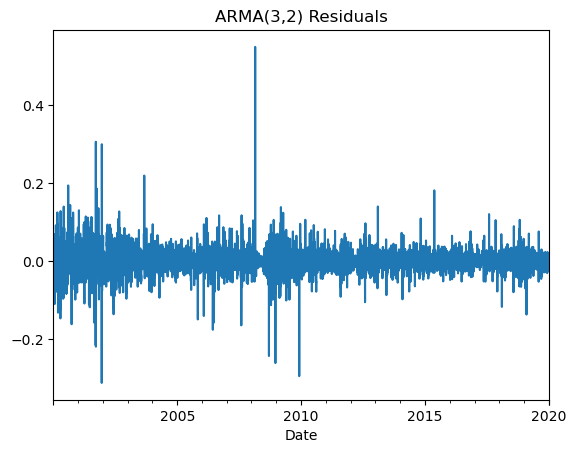

In [31]:
models_fit['3 2'].resid.plot()
plt.title("ARMA(3,2) Residuals")

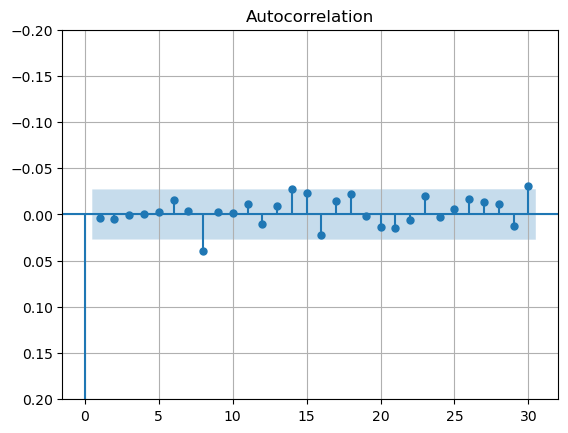

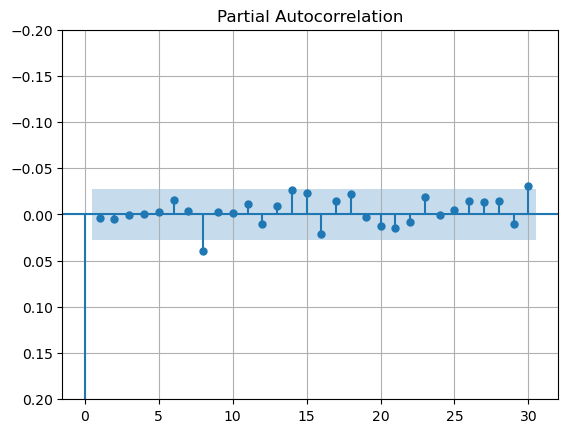

In [32]:
# Plotting ACF and PACF
plot_acf(models_fit['3 2'].resid, lags=30, alpha=0.05)
plt.ylim(0.2,-0.2)
plt.grid()

plot_pacf(models_fit['3 2'].resid, lags=30, alpha=0.05, method="ols")
plt.ylim(0.2,-0.2)
plt.grid()

### Simple ARIMA model

In [33]:
model = ARIMA(df_train[ 't2i_returns'], order=(4,1,4))
# Note, we are already using returns so this means I is of order 2
model_predictor(model, df_test[ 't2i_returns'])

d:\program_files\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(4, 1, 4)   Log Likelihood               10534.706
Date:                Sun, 19 Jan 2025   AIC                         -21051.412
Time:                        05:39:56   BIC                         -20992.364
Sample:                    01-04-2000   HQIC                        -21030.762
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2469      0.392     -3.178      0.001      -2.016      -0.478
ar.L2         -1.2881      0.177     -7.274      0.000      -1.635      -0.941
ar.L3         -0.8680      0.369     -2.354      0.019      -1.591      -0.145
ar.L4         -0.0239      0.019     -1.257      0.209      -0.061       0.013
ma.L1          0.2204      0.393      0.561      0.575      -0.549       0.990
ma.L2          0.0343      0.249      0.138      0.891      -0.455       0.523
ma.L3         -0.4258      0.221     -1.927      0.054      -0.859       0.007
ma.L4         -0.8238      0.361     -2.283      0.022      -1.531      -0.117
sigma2         0.0010   5.78e-06    178.559      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            166035.83
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Notice how ARIMA has the same number of coefs as ARMA since it is only calculating integrals

### ARMA 4 4 model (cut offs of the ACF of the residuals of 3 2 model)

In [34]:
model = ARIMA(df_train[ 't2i_returns'], order=(4,0,4))
model_predictor(model, df_test[ 't2i_returns'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(4, 0, 4)   Log Likelihood               10548.221
Date:                Sun, 19 Jan 2025   AIC                         -21076.442
Time:                        05:40:00   BIC                         -21010.832
Sample:                    01-04-2000   HQIC                        -21053.498
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.262      0.024       0.000       0.002
ar.L1         -0.2034      2.688     -0.076      0.940      -5.472       5.065
ar.L2         -0.2205      2.377     -0.093      0.926      -4.880       4.439
ar.L3         -0.0598      1.872     -0.032      0.974      -3.728       3.609
ar.L4          0.2579      1.511      0.171      0.864      -2.703       3.219
ma.L1          0.1707      2.689      0.063      0.949      -5.100       5.442
ma.L2          0.1862      2.298      0.081      0.935      -4.318       4.690
ma.L3          0.0628      1.728      0.036      0.971      -3.325       3.450
ma.L4         -0.2368      1.430     -0.166      0.869      -3.040       2.566
sigma2         0.0010   6.02e-06    171.370      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):            165697.53
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Using ARMAX for analyzing data

ARMAX models can't be used for forecasting as they depend on existing test data, While in real world scenario's, test data is in the future.

d:\program_files\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\program_files\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            t2i_returns   No. Observations:                 5224
Model:                 ARIMA(3, 0, 2)   Log Likelihood               10616.547
Date:                Sun, 19 Jan 2025   AIC                         -21217.094
Time:                        05:40:03   BIC                         -21164.606
Sample:                    01-04-2000   HQIC                        -21198.739
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0009      0.000      2.141      0.032    7.67e-05       0.002
ubisoft_returns     0.1669      0.008     20.987      0.000       0.151       0.182
ar.L1              -0.0271     68.004     -0.000      1.000    -133.312     133.258
ar.L2              -0.0141      8.546     -0.002      0.999     -16.765      16.737
ar.L3               0.0035      2.214      0.002      0.999      -4.335       4.342
ma.L1              -0.0265     68.003     -0.000      1.000    -133.311     133.258
ma.L2              -0.0132      4.906     -0.003      0.998      -9.628       9.602
sigma2              0.0010   5.36e-06    187.368      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            185886.41
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

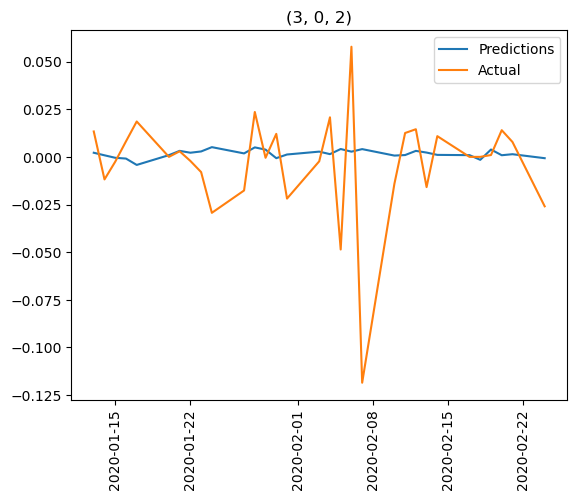

In [35]:
# Adding Exogenous Variables
model = ARIMA(df_train[ 't2i_returns'], exog=df_train['ubisoft_returns'], order=(3,0,2))
model_predictor(model, df_test[ 't2i_returns'],n_predictions=30, exog=df_test['ubisoft_returns'],plot=True)

### SARMA

In [36]:
# Finding seasonal cufoffs in ACF and PACF
%matplotlib qt
acf = plot_acf(df['t2i_returns'], lags=90)
plt.plot([0,37], [0.05,0.05])
plt.plot([0,37], [-0.05,-0.05])
plt.ylim(0.1,-0.1)
plt.grid()
pacf = plot_pacf(df['t2i_returns'], lags=90)
plt.plot([0,37], [0.05,0.05])
plt.plot([0,37], [-0.05,-0.05])
plt.ylim(0.1,-0.1)
plt.grid()

In [37]:
df.iloc[:10]

,t2i,UBI.PA,t2i_returns,ubisoft_returns
Date,,,,
2000-01-04,8.874452,49.250000,-0.027397,-0.052885
2000-01-05,8.832788,46.825001,-0.004695,-0.049239
2000-01-06,8.749459,47.875000,-0.009434,0.022424
2000-01-07,8.999444,47.150002,0.028571,-0.015144
2000-01-10,9.166101,50.849998,0.018519,0.078473
2000-01-11,8.957780,50.500000,-0.022727,-0.006883
2000-01-12,8.666132,50.500000,-0.032558,0.000000
2000-01-13,9.291093,53.750000,0.072115,0.064356
2000-01-14,9.541078,57.750000,0.026906,0.074419


Lets try Seasonal order (4,0,0,5) to incoperate the previous 4 weeks

In [38]:
# Investigating weekly seasonality
model = SARIMAX(df_train[ 't2i_returns'], order=(3,0,2), seasonal_order=(4,0,4,5))
model_predictor(model, df_test[ 't2i_returns'], plot = True)

d:\program_files\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                  t2i_returns   No. Observations:                 5224
Model:             SARIMAX(3, 0, 2)x(4, 0, [1, 2, 3, 4], 5)   Log Likelihood               10553.143
Date:                                      Sun, 19 Jan 2025   AIC                         -21078.286
Time:                                              05:40:30   BIC                         -20986.432
Sample:                                          01-04-2000   HQIC                        -21046.164
                                               - 01-10-2020                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9083      0.070    -12.899      0.000      -1.046      -0.770
ar.L2         -0.8956      0.055    -16.416      0.000      -1.002      -0.789
ar.L3         -0.0445      0.011     -4.232      0.000      -0.065      -0.024
ma.L1          0.8819      0.070     12.588      0.000       0.745       1.019
ma.L2          0.8419      0.058     14.614      0.000       0.729       0.955
ar.S.L5       -0.1877      2.181     -0.086      0.931      -4.463       4.087
ar.S.L10      -0.1319      1.676     -0.079      0.937      -3.418       3.154
ar.S.L15      -0.1165      1.291     -0.090      0.928      -2.647       2.414
ar.S.L20       0.0869      0.936      0.093      0.926      -1.748       1.922
ma.S.L5        0.1785      2.183      0.082      0.935      -4.099       4.456
ma.S.L10       0.1302      1.657      0.079      0.937      -3.117       3.377
ma.S.L15       0.0937      1.277      0.073      0.942      -2.410       2.597
ma.S.L20      -0.0687      0.884     -0.078      0.938      -1.801       1.664
sigma2         0.0010   6.13e-06    167.649      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            166715.07
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA Model isn't significantly better significantly

# Auto Arima

In [60]:
model = auto_arima(df_train['t2i_returns'][1:],
                  start_p=0, start_q=0,  # starting values for p, q
                  max_p=5, max_q=5,      # maximum values for p, q
                  m=7,                   # frequency of the data (7 for weekly seasonality)
                  maxiter = 50,
                  alpha = 0.05, 
                  seasonal=True,         # include seasonal component
                  d=1,                   # difference order
                  D=1,                   # seasonal difference order
                  n_jobs = -1, 
                  trace=True,            # print model fitting progress
                  error_action='ignore', # ignore orders that don't work
                  suppress_warnings=True, # suppress warnings
                  information_criterion = 'oob',
                  out_of_sample = int(len(df)*0.2),
                  stepwise=True)         # use stepwise search


d:\program_files\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
d:\program_files\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=4.14 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-13724.302, Time=0.95 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-16532.335, Time=1.65 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=6.93 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-15288.817, Time=0.54 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-17224.827, Time=4.13 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=26.80 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=9.44 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-15717.991, Time=3.98 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-17989.634, Time=4.78 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-17295.131, Time=3.54 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=18.87 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=15.45 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=-18401.710, Time=8.18 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=-1

In [120]:
period = 22*3
forecast, conf_int = model.predict(n_periods=period, 
                                 return_conf_int=True,
                                 alpha=0.05) 
future_dates = pd.date_range(start=df_test['t2i_returns'].index[0] + timedelta(days=1),
                            periods=period,
                            freq='B')
df_pred = model.predict(n_periods = period, freq = 'B')

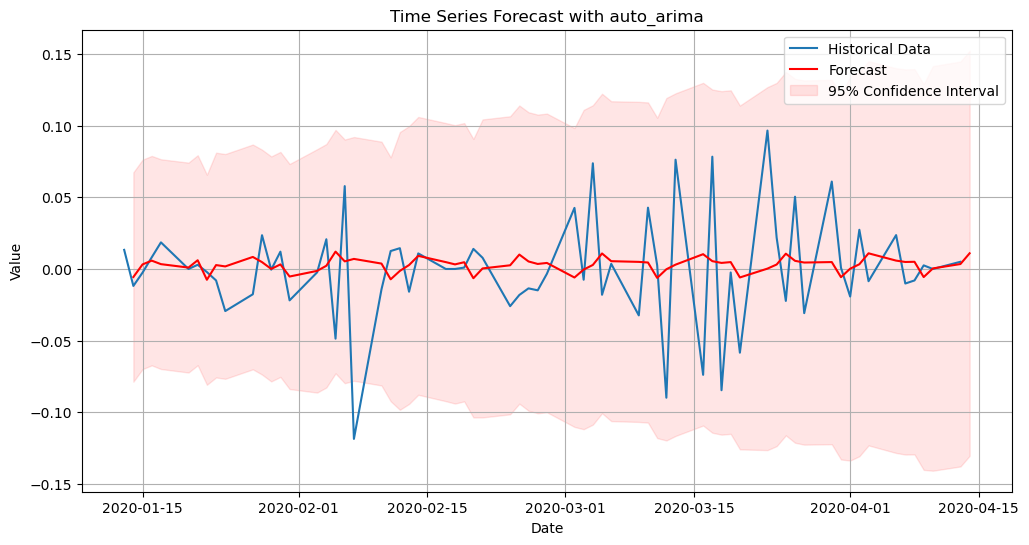

In [121]:
# Plot the results
%matplotlib inline
plt.figure(figsize=(12, 6))
plt.plot(df_test['t2i_returns'][:period].index, df_test['t2i_returns'][:period], label='Historical Data')
plt.plot(future_dates, forecast, color='red', label='Forecast')
plt.fill_between(future_dates,
                conf_int[:, 0],
                conf_int[:, 1],
                color='red',
                alpha=0.1,
                label='95% Confidence Interval')
plt.title('Time Series Forecast with auto_arima')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [85]:
model_ubi = auto_arima(df_train['t2i_returns'],
                  start_p=0, start_q=0,  # starting values for p, q
                  max_p=5, max_q=5,      # maximum values for p, q
                  m=7,                   # frequency of the data (7 for weekly seasonality)
                  maxiter = 50,
                  alpha = 0.05, 
                  seasonal=True,         # include seasonal component
                  d=1,                   # difference order
                  D=1,                   # seasonal difference order
                  n_jobs = -1, 
                  trace=True,            # print model fitting progress
                  error_action='ignore', # ignore orders that don't work
                  suppress_warnings=True, # suppress warnings
                  information_criterion = 'oob',
                  out_of_sample = int(len(df)*0.2),
                  stepwise=True)         # use stepwise search


d:\program_files\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
d:\program_files\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=4.23 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-13724.302, Time=1.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-16532.335, Time=1.90 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=5.93 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-15288.817, Time=0.54 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-17224.827, Time=4.16 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=24.62 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=8.76 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-15717.991, Time=3.60 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-17989.634, Time=5.02 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-17295.131, Time=4.25 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=19.60 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=16.11 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=-18401.710, Time=8.76 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=-1

**ARIMA(5,1,1)(2,1,0)[7]** is selected for both **Ubisoft** and **Take-Two Interactive** because:

1. **AR(5)**: Both stocks show significant dependency on past 5 values.
2. **d = 1**: First differencing removes trends in both time series.
3. **MA(1)**: Short-term shocks/errors impact predictions.
4. **Seasonal (2,1,0)[7]**: Both stocks exhibit weekly seasonality (7 periods), with 2 past seasonal values influencing the forecast and 1 seasonal differencing to remove trends.

These similarities in data characteristics led **AutoARIMA** to choose the same model for both.

In [122]:
period = 22*3
forecast, conf_int = model.predict(n_periods=period, 
                                 return_conf_int=True,
                                 alpha=0.05) 
future_dates = pd.date_range(start=df_test['ubisoft_returns'].index[0] + timedelta(days=1),
                            periods=period,
                            freq='B')
df_pred = model.predict(n_periods = period, freq = 'B')

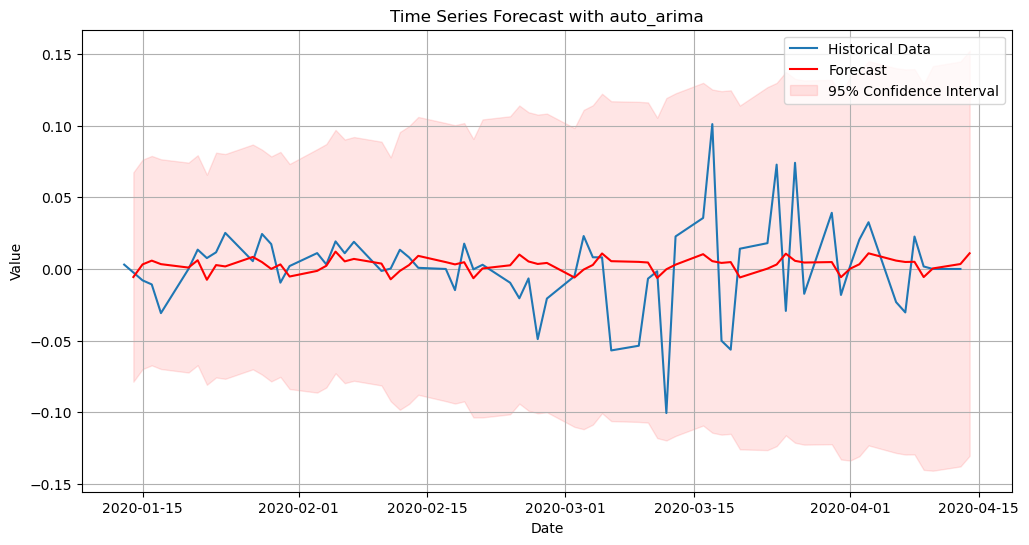

In [124]:
# Plot the results
%matplotlib inline
plt.figure(figsize=(12, 6))
plt.plot(df_test['ubisoft_returns'][:period].index, df_test['ubisoft_returns'][:period], label='Historical Data')
plt.plot(future_dates, forecast, color='red', label='Forecast')
plt.fill_between(future_dates,
                conf_int[:, 0],
                conf_int[:, 1],
                color='red',
                alpha=0.1,
                label='95% Confidence Interval')
plt.title('Time Series Forecast with auto_arima')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [171]:
from arch import arch_model

In [163]:
model_garch_1_ubi = arch_model(df['ubisoft_returns'], mean = "constant",  vol = "GARCH", p = 1, q = 1, dist = "Normal")
results_garch_1_ubi = model_garch_1_ubi.fit(update_freq = 5, last_obs = df_train.index[-1])
results_garch_1_ubi.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -11327.984091738042
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 4


d:\program_files\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:        ubisoft_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11328.0
Distribution:                  Normal   AIC:                          -22648.0
Method:            Maximum Likelihood   BIC:                          -22621.7
                                        No. Observations:                 5223
Date:                Sun, Jan 19 2025   Df Residuals:                     5222
Time:                        11:23:10   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.4059e-03  3.769e-04      3.730  1.914e-04 [6.671e-04,2.145e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0529e-05  6.337e-07     32.394 3.338e-230 [1.929e-05,2.177e-05]
alpha[1]       0.0500  1.732e-02      2.887  3.892e-03 [1.605e-02,8.395e-02]
beta[1]        0.9300  1.310e-02     71.014      0.000     [  0.904,  0.956]
============================================================================

Covariance estimator: robust
"""

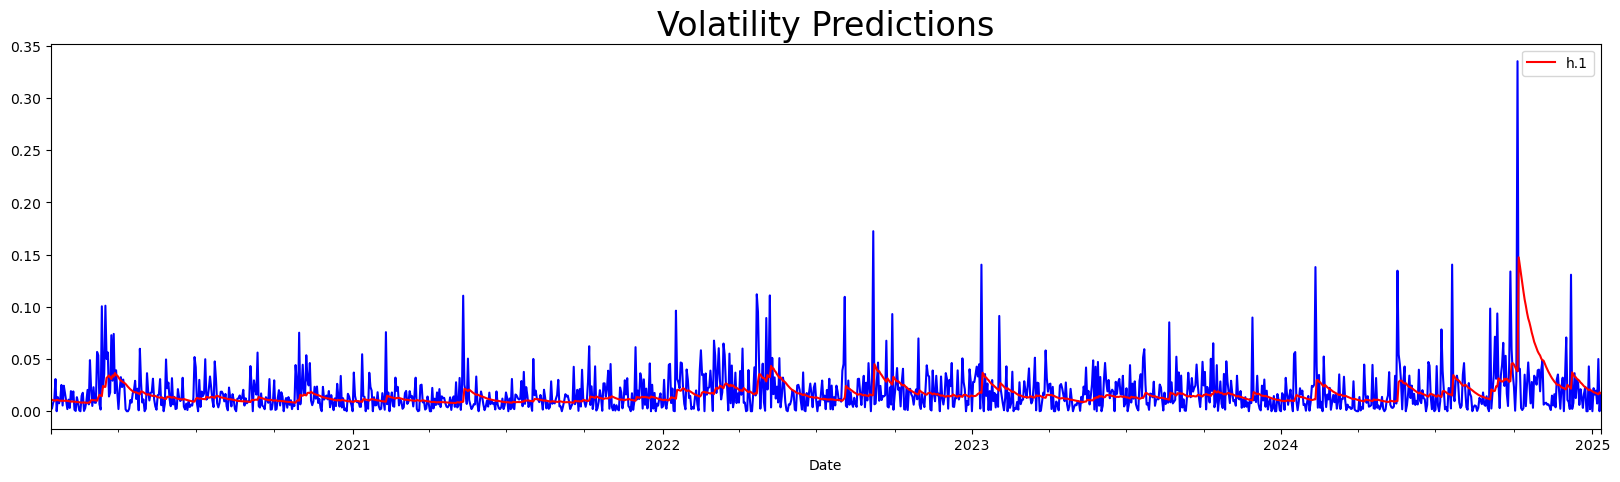

In [185]:
pred_garch_ubi = results_garch_1_ubi.forecast(horizon = 1, 
                                          align = 'target')
(pred_garch_ubi.residual_variance[df_test.index[1]:]*20).plot(figsize = (20,5), color = "red", zorder = 2)
df_test['ubisoft_returns'].abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [182]:
model_garch_1_t2i = arch_model(df['t2i_returns'], mean = "constant",  vol = "GARCH", p = 1, q = 1, dist = "Normal")
results_garch_1_t2i = model_garch_1_t2i.fit(update_freq = 5,last_obs = df_test.index[0])
results_garch_1_t2i.summary()# Plot the results

Optimization terminated successfully    (Exit mode 0)
            Current function value: -11069.477031304386
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


d:\program_files\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            t2i_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11069.5
Distribution:                  Normal   AIC:                          -22131.0
Method:            Maximum Likelihood   BIC:                          -22104.7
                                        No. Observations:                 5224
Date:                Sun, Jan 19 2025   Df Residuals:                     5223
Time:                        11:33:27   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2439e-03  3.533e-04      3.521  4.304e-04 [5.514e-04,1.936e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0711e-05  7.863e-07     26.341 6.553e-153 [1.917e-05,2.225e-05]
alpha[1]       0.0500  1.039e-02      4.810  1.509e-06 [2.963e-02,7.037e-02]
beta[1]        0.9300  1.001e-02     92.883      0.000     [  0.910,  0.950]
============================================================================

Covariance estimator: robust
"""

### Ubisoft Stock:
omega: 1.9534e-05 (Very small baseline volatility)
alpha[1]: 0.0500 (This indicates that past shocks (errors) have a relatively modest impact on future volatility)

beta[1]: 0.9300 (A very high beta, which indicates that past volatility has a significant impact on future volatility)

Interpretation for Ubisoft:

The high beta[1] suggests that volatility is very persistent, meaning once there’s an increase in volatility, it takes longer to return to lower levels.

The relatively low alpha[1] shows that the impact of recent shocks is less significant than the persistent volatility trend.

### Take-Two Interactive Stock:
omega: 2.5506e-05 (Slightly larger baseline volatility compared to Ubisoft)

alpha[1]: 0.1007 (This is higher than Ubisoft's alpha[1], indicating that recent shocks have a larger impact on future volatility for Take-Two)

beta[1]: 0.8801 (Still quite high, though lower than Ubisoft's beta[1], meaning volatility is persistent but slightly less than Ubisoft)
Interpretation for Take-Two Interactive:

Higher alpha[1] means that shocks (news, market events, etc.) have a more immediate impact on volatility, as compared to Ubisoft.

Lower beta[1] indicates slightly less persistence in volatility over time compared to Ubisoft.

Key Differences:
Persistence of Volatility:

Ubisoft has a stronger persistence in volatility (higher beta[1]), meaning once volatility rises, it remains elevated for a longer time.

Take-Two has a lower beta[1], meaning the volatility reverts to normal levels more quickly after a shock.

Impact of Shocks:

Take-Two's alpha[1] is higher, meaning it reacts more strongly to recent shocks compared to Ubisoft, where the impact of past errors is smaller.

Baseline Volatility (omega):

The baseline volatility (omega) is slightly higher for Take-Two, indicating a slightly higher average level of volatility in the stock over the sample period.

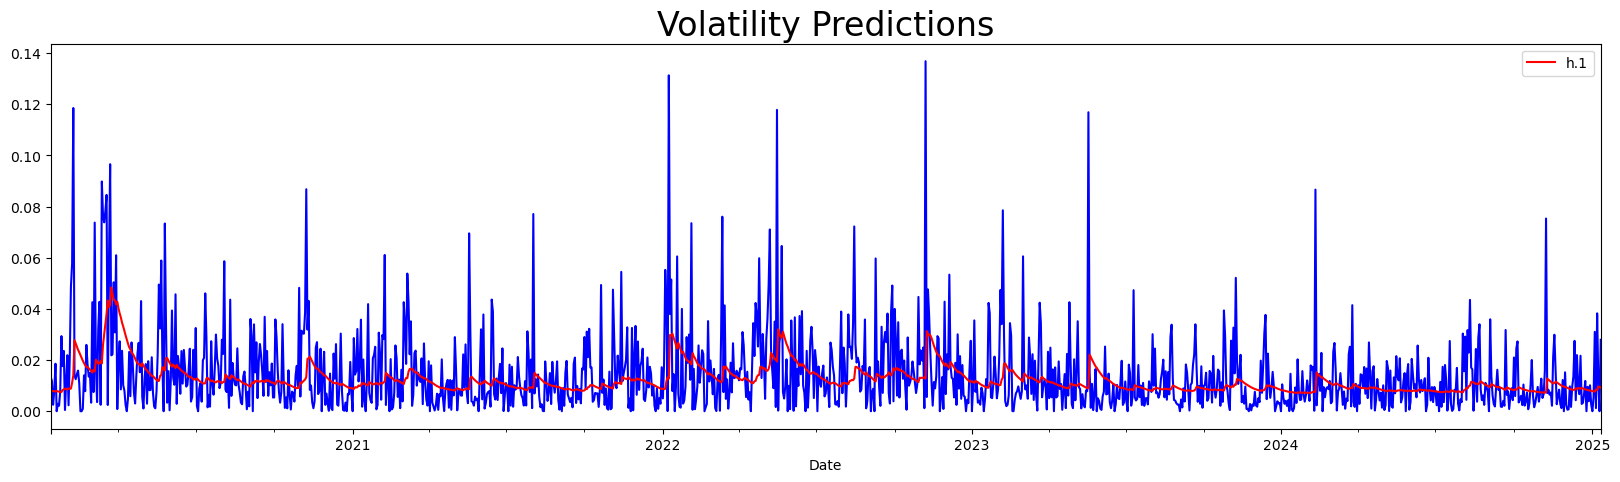

In [186]:
pred_garch_t2i = results_garch_1_t2i.forecast(horizon = 1, 
                                          align = 'target')
(pred_garch_t2i.residual_variance[df_test.index[0]:]*20).plot(figsize = (20,5), color = "red", zorder = 2)
df_test['t2i_returns'].abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

Ellipsis

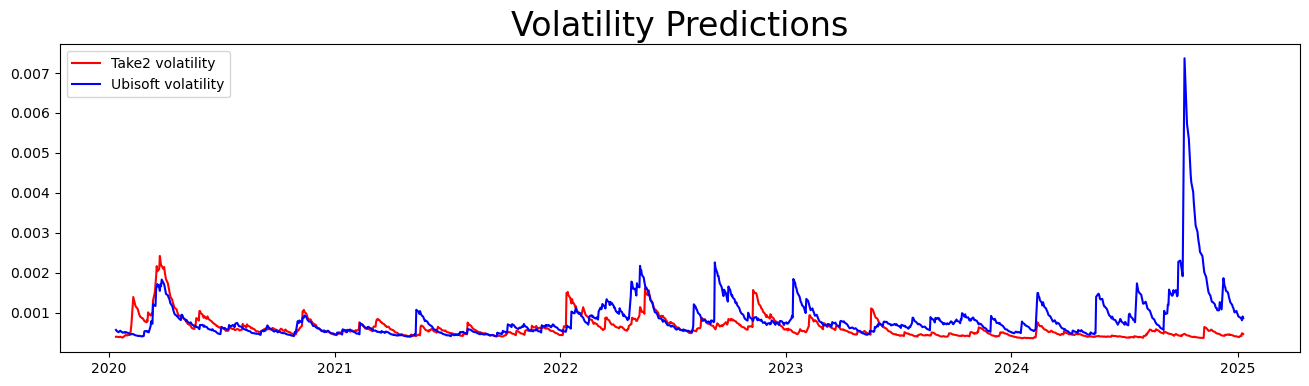

In [194]:
plt.figure(figsize=(16,4))
plt.plot(pred_garch_t2i.residual_variance[df_test.index[0]:], color = "red",label = "Take2 volatility")
plt.plot(pred_garch_ubi.residual_variance[df_test.index[0]:], color = "blue", label = "Ubisoft volatility")
plt.title("Volatility Predictions", size = 24)
plt.legend()
...

From the graph, we can deduce that:

1 - Both companies took a shock during covid

2 - Ubisoft had larger shocks in 2022 during their launch of AC Valhalla

3 - Ubisoft took massive shock in 2024

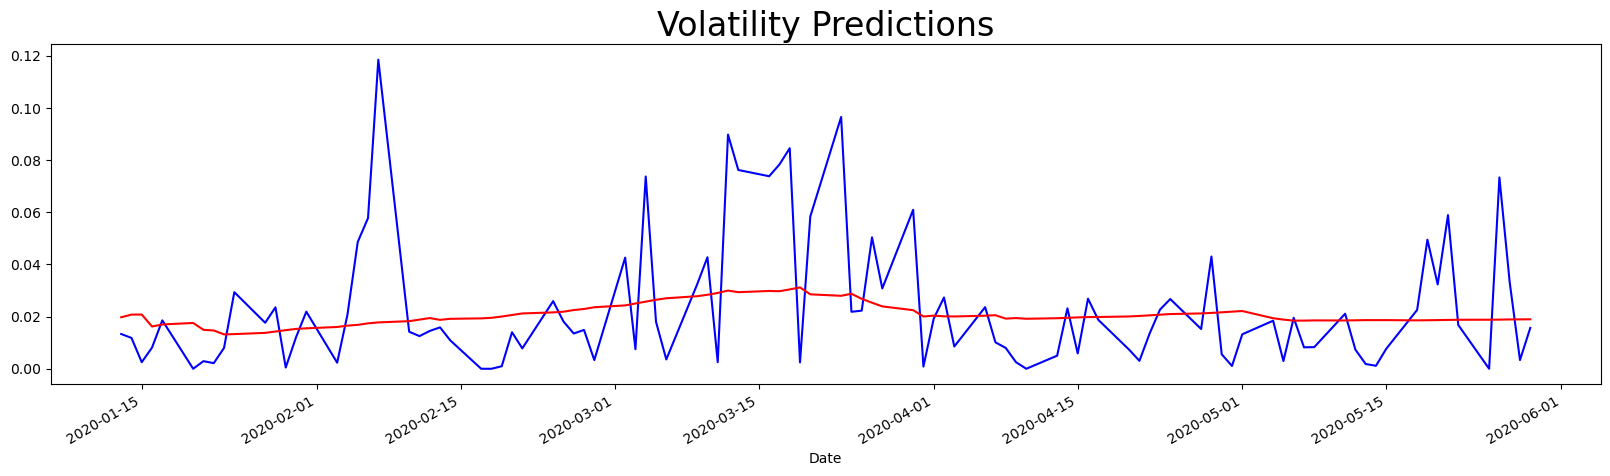

In [208]:
pred_garch_t2i = results_garch_1_t2i.forecast(horizon = 100, 
                                          align = 'target')

plt.figure( figsize = (20,5))
plt.plot(df_test.index[:100], (pred_garch_t2i.residual_variance.iloc[100]*20), color = "red", zorder = 2)
df_test['t2i_returns'][:100].abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

### As you can see, the model's predictive power of shocks decreases as the horizon increases

### Multvariate Regression Model
In this section, I will try to use VAR Algorithm to forecast how both companies will do in the future using their dependencies and get insights on how the Game developing market will behave in the future

In [210]:
from statsmodels.tsa.api import VAR

model_var_ret = VAR(df_train[['ubisoft_returns','t2i_returns']])
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [211]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 19, Jan, 2025
Time:                     12:00:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.7611
Nobs:                     5217.00    HQIC:                  -13.7856
Log likelihood:           21219.0    FPE:                1.01685e-06
AIC:                     -13.7988    Det(Omega_mle):     1.01103e-06
--------------------------------------------------------------------
Results for equation ubisoft_returns
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.000539         0.000442            1.220           0.223
L1.ubisoft_returns         0.007099         0.014047            0.505           0.613
L1.t2i_returns             0.1

From results, we see that the two companies have 16% correlation.

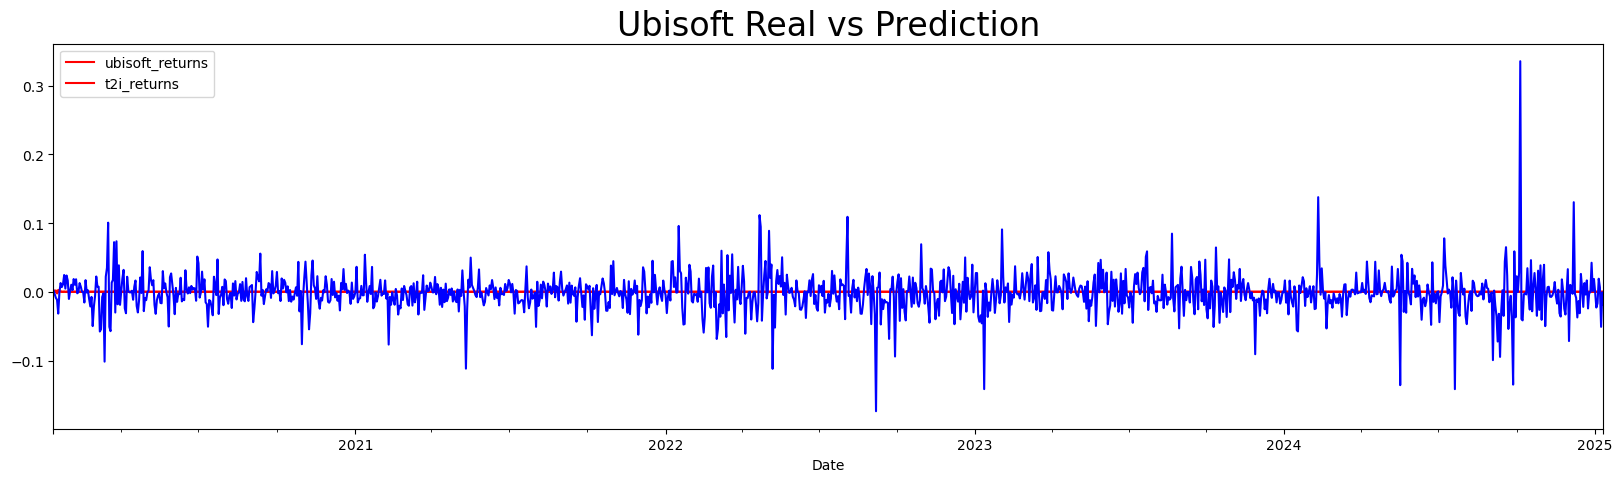

In [216]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_train[['ubisoft_returns','t2i_returns']].values[-lag_order_ret:], len(df_test))

df_pred = pd.DataFrame(data = var_pred_ret, index = df_test.index,
                                columns = ['ubisoft_returns','t2i_returns'])

df_pred.plot(figsize = (20,5), color = "red")

df_test['ubisoft_returns'].plot(color = "blue")
plt.title("Ubisoft Real vs Prediction", size = 24)
plt.show()

<Figure size 1500x600 with 0 Axes>

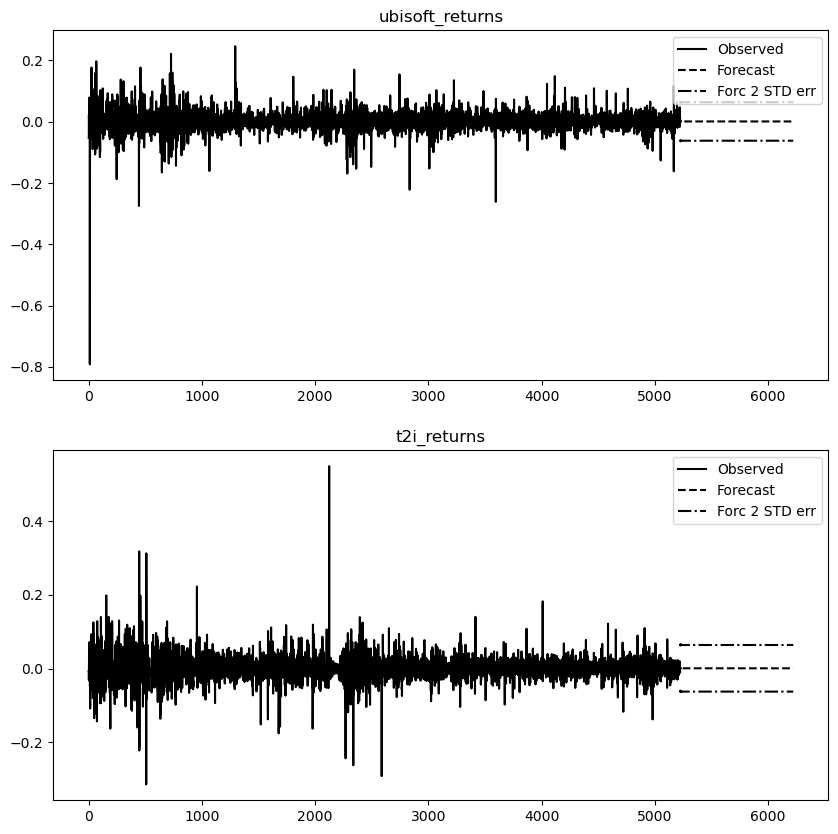

In [ ]:
plt.figure(figsize=(15,6))
results_var_ret.plot_forecast(1000, )
plt.show()